In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


# --- Limpieza de datos según lo indicado ---
df = pd.read_csv('titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

# Variables predictoras y variable objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# Crea un gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
roc_auc_score(y_pred, y_test)

np.float64(0.8042247386759582)

In [7]:
## Cross validation 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('gbt', GradientBoostingClassifier(n_estimators=300))
])

params = {
    'gbt__max_depth': [4, 5, 6], 
    'gbt__learning_rate': [0.01, 0.1, 0.5]
}

grid_gbt = GridSearchCV(estimator=pipeline, cv=3, n_jobs=-1, scoring='roc_auc', param_grid=params)

grid_gbt.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('gbt',
                                        GradientBoostingClassifier(n_estimators=300))]),
             n_jobs=-1,
             param_grid={'gbt__learning_rate': [0.01, 0.1, 0.5],
                         'gbt__max_depth': [4, 5, 6]},
             scoring='roc_auc')

In [8]:
# Mejor estimador 
best_grid_gbt = grid_gbt.best_estimator_.named_steps['gbt']

In [9]:
grid_gbt.best_params_

{'gbt__learning_rate': 0.01, 'gbt__max_depth': 4}

In [10]:
# AUC
predicciones = best_grid_gbt.predict_proba(X_test)[:,1]
roc_auc_score(y_true=y_test, y_score=predicciones)

np.float64(0.8259552042160737)

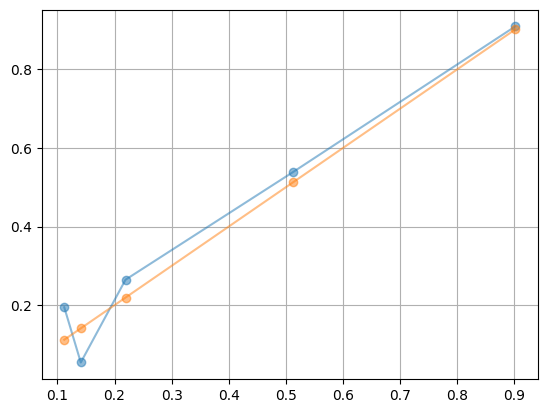

In [11]:
## Calibracion
df_calibrated = pd.DataFrame({
    'predicciones': predicciones,
    'y_true': y_test
})
df_calibrated['bins'] = pd.qcut(df_calibrated['predicciones'], q=5, labels=False) + 1

grouped = df_calibrated.groupby('bins').mean()

plt.plot(grouped.predicciones, grouped.y_true, marker="o", label="Modelo GBT", alpha=0.5)
plt.plot(grouped.predicciones, grouped.predicciones, marker="o", label="Modelo GBT", alpha=0.5)
plt.grid()

In [12]:
# Entendiendo el modelo 
df_importance = pd.DataFrame({
    'features': X_test.keys(),
    'importancia': best_grid_gbt.feature_importances_
})
df_importance.sort_values('importancia')

,features,importancia
7,Embarked_Q,0.001373
6,Embarked_C,0.003692
3,Parch,0.005486
8,Embarked_S,0.021692
2,SibSp,0.022508
4,Fare,0.137400
1,Age,0.152815
0,Pclass,0.166313
5,Sex_male,0.488720


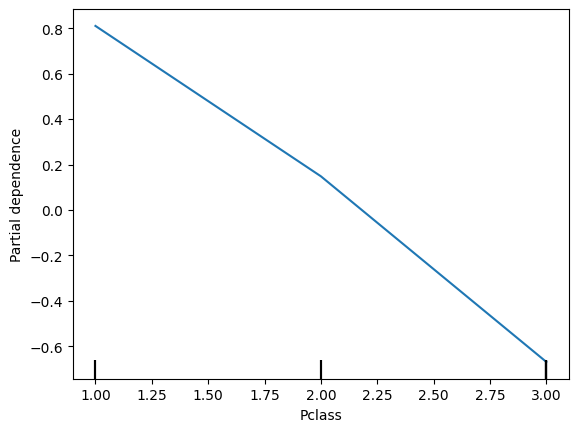

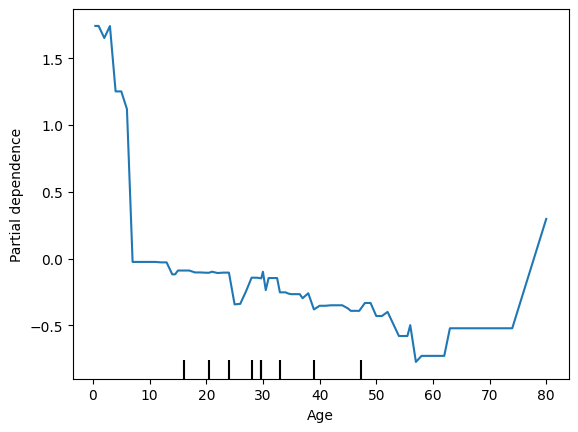

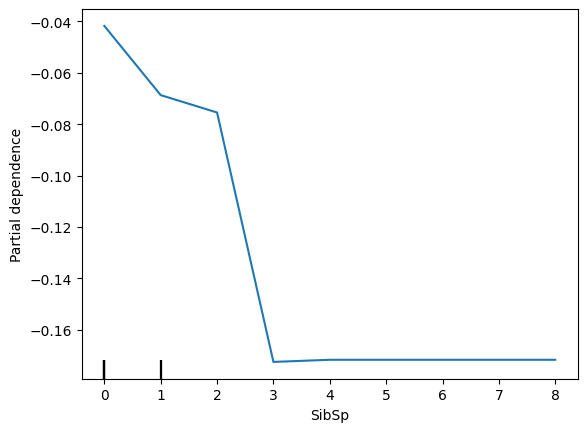

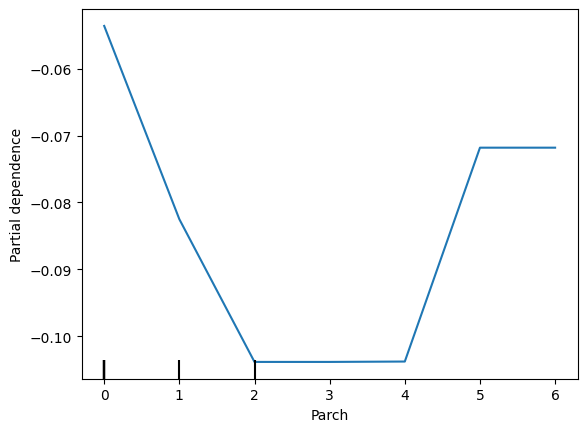

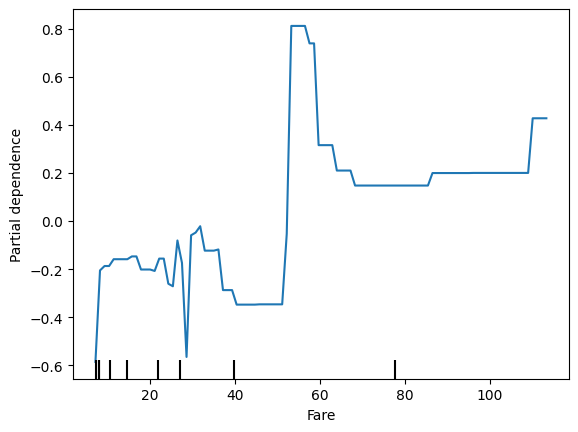

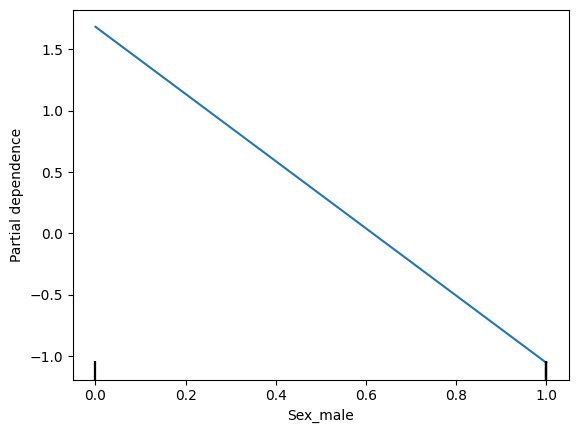

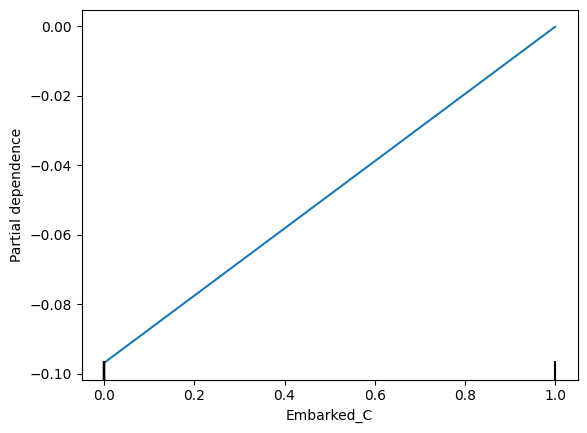

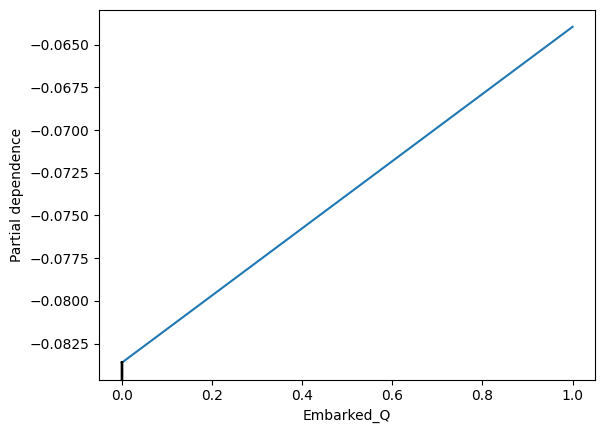

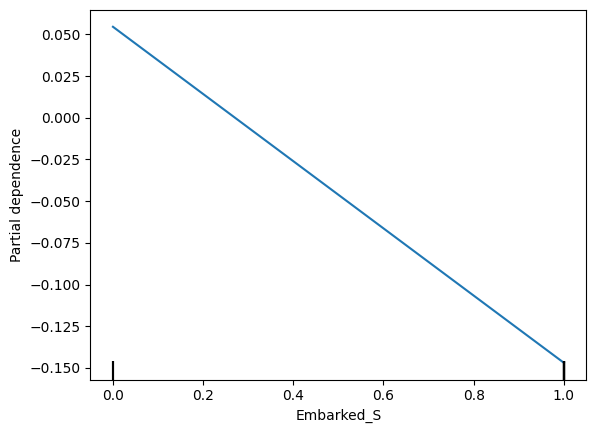

In [13]:
# Codigo for para partial dependence plot 
for i in X_train.keys():
    PartialDependenceDisplay.from_estimator(
        best_grid_gbt,
        X_train,
        [i],
        feature_names=X_train.columns
    )